# How To Ensemble OOF
In this notebook, we learn how to use `forward selection` to ensemble OOF. First build lots of models using the same KFolds (i.e. use same `seed`). Next save all the oof files as `oof_XX.csv` and submission files as `sub_XX.csv` where the oof and submission share the same `XX` number. Then save them in a Kaggle dataset and run the code below.

The ensemble begins with the model of highest oof AUC. Next each other model is added one by one to see which additional model increases ensemble AUC the most. The best additional model is kept and the process is repeated until the ensemble AUC doesn't increase.

# Read OOF Files

In [1]:
import pandas as pd, numpy as np, os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# PATH = '../input/melanoma-oof-and-sub/'
PATH = '../input/melanomas-oof/'
FILES = os.listdir(PATH)

OOF = np.sort( [f for f in FILES if ('oof' in f) and ('meta' not in f)] )
OOF_CSV = [pd.read_csv(PATH+k) for k in OOF]

print('We have %i oof files...'%len(OOF))
print(); print(OOF)

We have 20 oof files...

['129-oof.csv' '131-oof.csv' '132-oof.csv' '134-oof.csv' '136-oof.csv'
 '137-oof.csv' '138-oof.csv' '139-oof.csv' '140-oof.csv' '145-oof.csv'
 '146-oof.csv' '147-oof.csv' '149-oof.csv' '150-oof.csv' '151-oof.csv'
 '152-oof.csv' '153-oof.csv' '156-oof.csv' '157-oof.csv' '159-oof.csv']


In [3]:
x = np.zeros(( len(OOF_CSV[0]),len(OOF) ))
for k in range(len(OOF)):
    x[:,k] = OOF_CSV[k].pred.values
    
TRUE = OOF_CSV[0].target.values

In [4]:
all = []
for k in range(x.shape[1]):
    auc = roc_auc_score(OOF_CSV[0].target,x[:,k])
    all.append(auc)
    print('Model %i has OOF AUC = %.4f'%(k,auc))
    
m = [np.argmax(all)]; w = []

Model 0 has OOF AUC = 0.9101
Model 1 has OOF AUC = 0.9090
Model 2 has OOF AUC = 0.9082
Model 3 has OOF AUC = 0.9106
Model 4 has OOF AUC = 0.9202
Model 5 has OOF AUC = 0.9225
Model 6 has OOF AUC = 0.9222
Model 7 has OOF AUC = 0.9037
Model 8 has OOF AUC = 0.9367
Model 9 has OOF AUC = 0.9313
Model 10 has OOF AUC = 0.9305
Model 11 has OOF AUC = 0.9303
Model 12 has OOF AUC = 0.9283
Model 13 has OOF AUC = 0.9331
Model 14 has OOF AUC = 0.9304
Model 15 has OOF AUC = 0.9328
Model 16 has OOF AUC = 0.9289
Model 17 has OOF AUC = 0.9310
Model 18 has OOF AUC = 0.9382
Model 19 has OOF AUC = 0.9311


# Build OOF Ensemble. Maximize CV Score

In [5]:
old = np.max(all); 

RES = 200; 
PATIENCE = 10; 
TOL = 0.0003
DUPLICATES = False

print('Ensemble AUC = %.4f by beginning with model %i'%(old,m[0]))
print()

for kk in range(len(OOF)):
    
    # BUILD CURRENT ENSEMBLE
    md = x[:,m[0]]
    for i,k in enumerate(m[1:]):
        md = w[i]*x[:,k] + (1-w[i])*md
        
    # FIND MODEL TO ADD
    mx = 0; mx_k = 0; mx_w = 0
    print('Searching for best model to add... ')
    
    # TRY ADDING EACH MODEL
    for k in range(x.shape[1]):
        print(k,', ',end='')
        if not DUPLICATES and (k in m): continue
            
        # EVALUATE ADDING MODEL K WITH WEIGHTS W
        bst_j = 0; bst = 0; ct = 0
        for j in range(RES):
            tmp = j/RES*x[:,k] + (1-j/RES)*md
            auc = roc_auc_score(TRUE,tmp)
            if auc>bst:
                bst = auc
                bst_j = j/RES
            else: ct += 1
            if ct>PATIENCE: break
        if bst>mx:
            mx = bst
            mx_k = k
            mx_w = bst_j
            
    # STOP IF INCREASE IS LESS THAN TOL
    inc = mx-old
    if inc<=TOL: 
        print(); print('No increase. Stopping.')
        break
        
    # DISPLAY RESULTS
    print(); #print(kk,mx,mx_k,mx_w,'%.5f'%inc)
    print('Ensemble AUC = %.4f after adding model %i with weight %.3f. Increase of %.4f'%(mx,mx_k,mx_w,inc))
    print()
    
    old = mx; m.append(mx_k); w.append(mx_w)

Ensemble AUC = 0.9382 by beginning with model 18

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 
Ensemble AUC = 0.9445 after adding model 8 with weight 0.515. Increase of 0.0063

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 
Ensemble AUC = 0.9461 after adding model 17 with weight 0.190. Increase of 0.0016

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 
Ensemble AUC = 0.9469 after adding model 15 with weight 0.160. Increase of 0.0008

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 
No increase. Stopping.


In [6]:
print('We are using models',m)
print('with weights',w)
print('and achieve ensemble AUC = %.4f'%old)

We are using models [18, 8, 17, 15]
with weights [0.515, 0.19, 0.16]
and achieve ensemble AUC = 0.9469


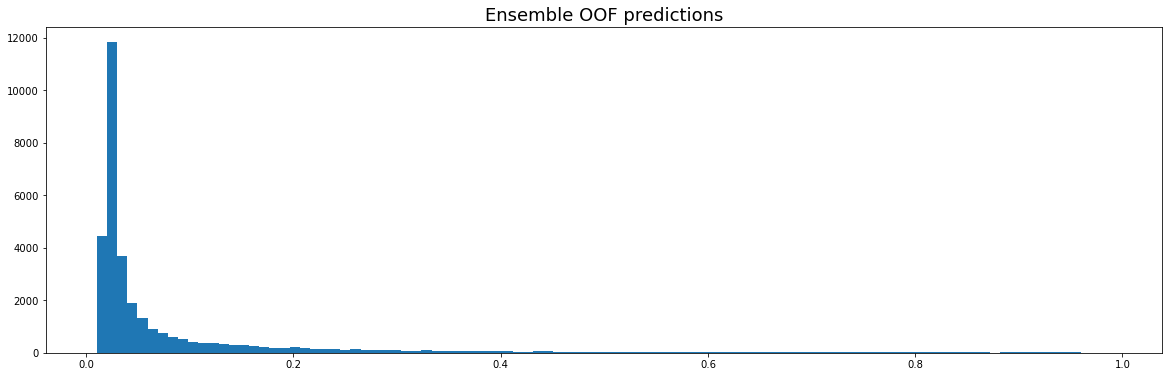

In [7]:
md = x[:,m[0]]
for i,k in enumerate(m[1:]):
    md = w[i]*x[:,k] + (1-w[i])*md

fig = plt.subplots(figsize=(20, 6))
plt.hist(md, bins=100)
plt.title('Ensemble OOF predictions', size=18)
plt.show()

In [8]:
df = OOF_CSV[0].copy()
df.pred = md
df.to_csv('ensemble_oof.csv',index=False)

# Load SUB Files

In [9]:
# PATH_SUB = '../input/melanoma-submissions/'
# FILES_SUB = os.listdir(PATH_SUB)

# SUB = np.sort( [f for f in FILES_SUB if 'sub' in f] )
# SUB_CSV = [pd.read_csv(PATH_SUB+k) for k in SUB]

# print('We have %i submission files...'%len(SUB))
# print(); print(SUB)

In [10]:
# # VERFIY THAT SUBMISSION FILES MATCH OOF FILES
# a = np.array( [ int( x.split('_')[1].split('.')[0]) for x in SUB ] )
# b = np.array( [ int( x.split('_')[1].split('.')[0]) for x in OOF ] )
# if len(a)!=len(b):
#     print('ERROR submission files dont match oof files')
# else:
#     for k in range(len(a)):
#         if a[k]!=b[k]: print('ERROR submission files dont match oof files')

In [11]:
# y = np.zeros(( len(SUB_CSV[0]),len(SUB) ))
# for k in range(len(SUB)):
#     y[:,k] = SUB_CSV[k].target.values

# Build SUB Ensemble

In [12]:
# md2 = y[:,m[0]]
# for i,k in enumerate(m[1:]):
#     md2 = w[i]*y[:,k] + (1-w[i])*md2
# plt.hist(md2,bins=100)
# plt.show()

In [13]:
# df = SUB_CSV[0].copy()
# df.target = md2
# df.to_csv('ensemble_sub.csv',index=False)